# Example 3: Optimized hyperparameters

In [1]:
import sys
sys.path.append('../')
from lgcpspatial.load_data import Dataset

datadir  = '../example data/'
datasets = [
    'r2405_051216b_cell1816.mat',
    'R11_20190607_EC_02.mat'
]

## Grid search to find kernel hyperparameters with best evidence lower-bound

In [10]:
from lgcpspatial.hyperparameters import gridsearch_optimize

# Load a dataset
L      = 128 # Grid size for position bins
data   = Dataset.from_file(datadir+datasets[1]).prepare(L,doplot=False)
result = gridsearch_optimize(data)
bestindex,bestpars,bestresult,allresults = result

[101,108](1.17e+01,6.70e-01) loss=-4.837745e+03(done)

Heuristic parameters
P  = 11.499551
v0 = 0.069208

Optimized parameters:
P    = 11.499552
β    = 0.669750
v0/β = 0.103334


## The heuristic parameters were close to optimal in this case

***Note:*** Since each time-sample adds independent information, it is helpful to normalize the evidence lower bound (ELBO). 
By default, `coordinate_descent` returns the negative ELBO, sometimes called the variational free energy,
in units of nats-per-dataset. We can convert this to a more useful bits-per-second by:

1. Dividing by the total number of time samples, giving nats per sample
2. Multiply by `log2(e)` to convert to bits per sample
3. Multiplying by samples/second to get bits per second

This (negative) ELBO is also missing a $\ln(y!) = \ln\Gamma(y+1)$ term from the Poisson negative log-likelihood. This doesn't affect state or hyperparameter optimization, but it's good to add it back for completeness.

Text(0.5, 0.98, '<lgcpspatial.load_data.Dataset object at 0x7fa68d544280>: Optimised parameters, ELBO=-0.728810 bits/second')

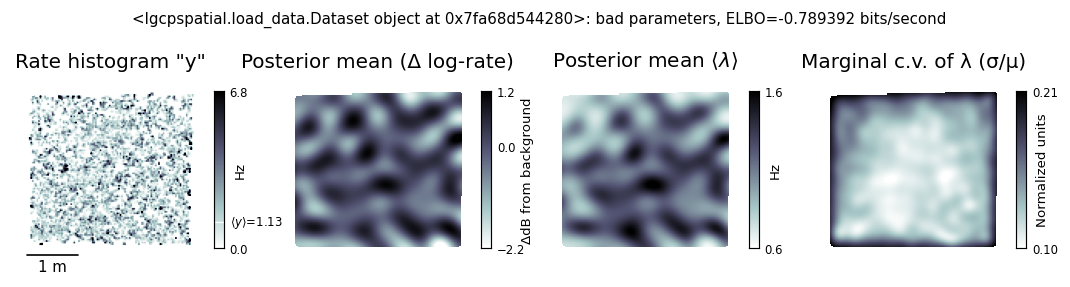

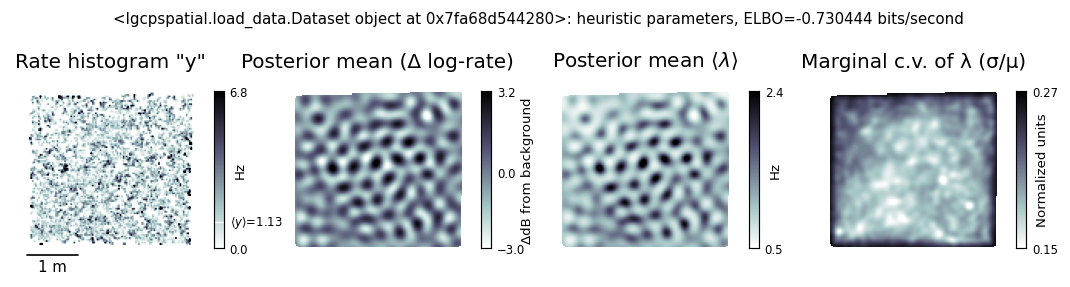

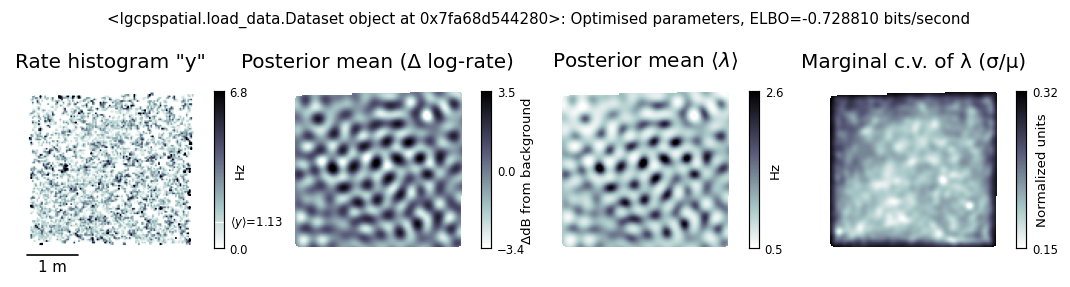

In [55]:
from lgcpspatial.lgcp2d import DiagonalFourierLowrank
from lgcpspatial.lgcp2d import coordinate_descent
from scipy.special      import loggamma as lnΓ
from lgcpspatial.plot   import *

mask,mz = data.arena.mask,data.prior_mean
Fs      = data.position_sample_rate
scale   = data.scale
y,N     = data.y,data.n

inbitspers = log2(e)*Fs
correction = average(lnΓ(data.y+1),weights=data.n)

totaltime = sum(N)

def to_bps(vfe):
    '''
    The DiagonalFourierLowrank class returns the
    variational free energy in units of nats per dataset,
    with the constant contribution from the spikes
    removed. 
    
    This converts our result back to bits per spike,
    adding back this constant contribution.
    '''
    return -inbitspers*(vfe/totaltime+correction)
    

# Heuristic kernel parameters
P  = data.P
kv = data.prior_variance

P_use    = P*2
v0_use   = kv
model    = DiagonalFourierLowrank(v0_use,P_use,data)
mh,v,vfe = coordinate_descent(model,tol=1e-6)
inference_summary_plot(model,mask,y,mh,mz,v,Fs,L,scale,data)
suptitle('%s: bad parameters, ELBO=%f bits/second'%\
         (data,to_bps(vfe)))

P_use    = P
v0_use   = kv
model    = DiagonalFourierLowrank(v0_use,P_use,data)
mh,v,vfe = coordinate_descent(model,tol=1e-6)
inference_summary_plot(model,mask,y,mh,mz,v,Fs,L,scale,data)
suptitle('%s: heuristic parameters, ELBO=%f bits/second'%\
         (data,to_bps(vfe)))

P_use    = bestpars[0]
v0_use   = kv/bestpars[1]
model    = DiagonalFourierLowrank(v0_use,P_use,data)
mh,v,vfe = coordinate_descent(model,tol=1e-6)
inference_summary_plot(model,mask,y,mh,mz,v,Fs,L,scale,data)
suptitle('%s: Optimised parameters, ELBO=%f bits/second'%\
         (data,to_bps(vfe)))

## Detailed parameter sweep to visualize for the paper

Sweeping kernel prior variance
Sweeping kernel period                                                


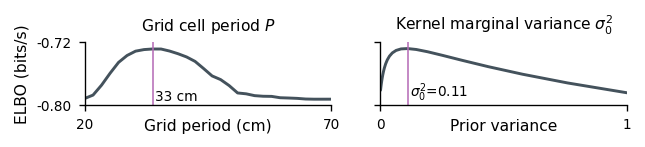

In [125]:
from lgcpspatial.util import progress_bar

print('Sweeping kernel prior variance')
vs = exp(linspace(-8,log(1),30))
elbo_v = float32([
    coordinate_descent(DiagonalFourierLowrank(v,P_use,data))[2]\
    for v in progress_bar(vs)])

print('Sweeping kernel period')
ps = linspace(20/100*data.L*data.scale,70/100*data.L*data.scale,30)
elbo_p = float32([
    coordinate_descent(DiagonalFourierLowrank(v0_use,p,data),tol=1e-7)[2]\
    for p in progress_bar(ps)])

Fs    = 50
N     = len(data.px)/Fs
y0,y1 = -.8,-.72

figure(0,(5,.6),dpi=140)
subplot(121)
x = ps/data.scale/data.L*100
y = to_bps(elbo_p)
plot(x,y)
simpleaxis()
title('Grid cell period $P$')
xlabel('Grid period (cm)',labelpad=-7)
xticks([20,70])
ylabel('ELBO (bits/s)')
ylim(y0,y1)
yticks([y0,y1],['%.2f'%y0,'%.2f'%y1])
best = argmax(y)
axvline(x[best],lw=.8,color=MAUVE)
text(x[best]+px2x(2),ylim()[0]+px2y(2),'%d cm'%x[best],va='bottom',fontsize=7)
subplot(122)
x,y = vs,to_bps(elbo_v)
plot(x,y)
simpleaxis()
title('Kernel marginal variance $\\sigma_0^2$')
xlabel('Prior variance',labelpad=-7)
xticks([0,1])
ylim(y0,y1)
yticks([y0,y1],['',''])
best = argmax(y)
axvline(x[best],lw=.8,color=MAUVE)
text(x[best]+px2x(2),ylim()[0]+px2y(2),'$\\sigma^2_0$=%0.2f'%x[best],va='bottom',fontsize=7)
savefig('fig3b.svg')